In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Se añade TimeSeriesSplit a las importaciones
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.base import clone # Importación clave para la solución


In [20]:
try:
    project_root = Path.cwd().parent
    processed_path = project_root / "data" / "processed"
    
    df_full = pd.read_csv(processed_path / "features_clasificacion.csv")
    df_reduced = pd.read_csv(processed_path / "features_reducido_clasificacion.csv")
    
    print("Datasets cargados exitosamente.")
    print(f"Forma del dataset completo: {df_full.shape}")
    print(f"Forma del dataset reducido: {df_reduced.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta: {e}")
    df_full = None
    df_reduced = None


Datasets cargados exitosamente.
Forma del dataset completo: (30000, 36)
Forma del dataset reducido: (30000, 12)


In [27]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name, dataset_name):
    """
    Entrena y evalúa un modelo de clasificación en datos ya divididos temporalmente.
    """
    feature_names_list = X_train.columns.tolist()

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train_res)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'F1-Score (Default)': f1_score(y_test, y_pred, pos_label=1),
        'artifacts': {
            'feature_names': feature_names_list,
            'y_test': y_test,
            'y_pred_proba': y_pred_proba,
            'model': model,
            
            # --- LÍNEAS AÑADIDAS DE VUELTA ---
            # Guardar los datos necesarios para la optimización de hiperparámetros.
            'X_train_scaled': X_train_scaled,
            'y_train_res': y_train_res,
            'X_test_scaled': X_test_scaled
            # --- FIN DE LAS LÍNEAS AÑADIDAS ---
        }
    }

    print(f"\n--- Resultados para {model_name} en {dataset_name} ---")
    print(classification_report(y_test, y_pred, target_names=['No Incumplimiento', 'Incumplimiento']))

    return metrics

In [28]:
if df_full is not None and df_reduced is not None:
    
    datasets_dfs = {
        "Completo": df_full,
        "Reducido": df_reduced
    }
    
    # Se renombra a "prototypes" para indicar que son plantillas a clonar
    model_prototypes = {
        "Regresión Logística": LogisticRegression(random_state=42, max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    results = []
    
    for d_name, df_data in datasets_dfs.items():
        df_sorted = df_data.sort_values('ID').reset_index(drop=True)
        
        split_point = int(len(df_sorted) * 0.8)
        train_df = df_sorted.iloc[:split_point]
        test_df = df_sorted.iloc[split_point:]
        
        target_col = 'default_payment_next_month'
        features_to_use = df_data.select_dtypes(include=np.number).columns.drop([target_col, 'ID'], errors='ignore').tolist()
        
        X_train = train_df[features_to_use]
        y_train = train_df[target_col]
        X_test = test_df[features_to_use]
        y_test = test_df[target_col]
        
        # Iterar sobre cada prototipo de modelo
        for m_name, model_proto in model_prototypes.items():
            # --- SOLUCIÓN IMPLEMENTADA ---
            # Clonar el modelo para asegurar una instancia limpia en cada entrenamiento
            model_instance = clone(model_proto)
            
            metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_instance, m_name, d_name)
            results.append(metrics)
            
    results_df = pd.DataFrame(results)
    
    print("\n--- Tabla Comparativa de Rendimiento de Modelos ---")
    display(results_df.drop(columns=['artifacts']))


--- Resultados para Regresión Logística en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.87      0.75      0.80      4734
   Incumplimiento       0.38      0.58      0.46      1266

         accuracy                           0.71      6000
        macro avg       0.62      0.66      0.63      6000
     weighted avg       0.77      0.71      0.73      6000


--- Resultados para Random Forest en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.86      0.90      0.88      4734
   Incumplimiento       0.55      0.46      0.50      1266

         accuracy                           0.81      6000
        macro avg       0.71      0.68      0.69      6000
     weighted avg       0.80      0.81      0.80      6000



/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:43:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1754001896909/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados para XGBoost en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.85      0.89      0.87      4734
   Incumplimiento       0.52      0.43      0.47      1266

         accuracy                           0.79      6000
        macro avg       0.68      0.66      0.67      6000
     weighted avg       0.78      0.79      0.79      6000


--- Resultados para Regresión Logística en Reducido ---
                   precision    recall  f1-score   support

No Incumplimiento       0.87      0.71      0.78      4734
   Incumplimiento       0.35      0.59      0.44      1266

         accuracy                           0.68      6000
        macro avg       0.61      0.65      0.61      6000
     weighted avg       0.76      0.68      0.71      6000


--- Resultados para Random Forest en Reducido ---
                   precision    recall  f1-score   support

No Incumplimiento       0.86      0.87      0.87      4734
   Incumplimie

/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:43:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1754001896909/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Dataset,Accuracy,ROC-AUC,F1-Score (Default)
0,Regresión Logística,Completo,0.711167,0.717633,0.460293
1,Random Forest,Completo,0.808167,0.767896,0.504093
2,XGBoost,Completo,0.794667,0.754011,0.467128
3,Regresión Logística,Reducido,0.683167,0.697875,0.441703
4,Random Forest,Reducido,0.791333,0.746551,0.494346
5,XGBoost,Reducido,0.788667,0.745435,0.486640



--- Análisis Profundo del Mejor Modelo: Random Forest en Dataset Completo ---


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_3049/1858210894.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='mako')


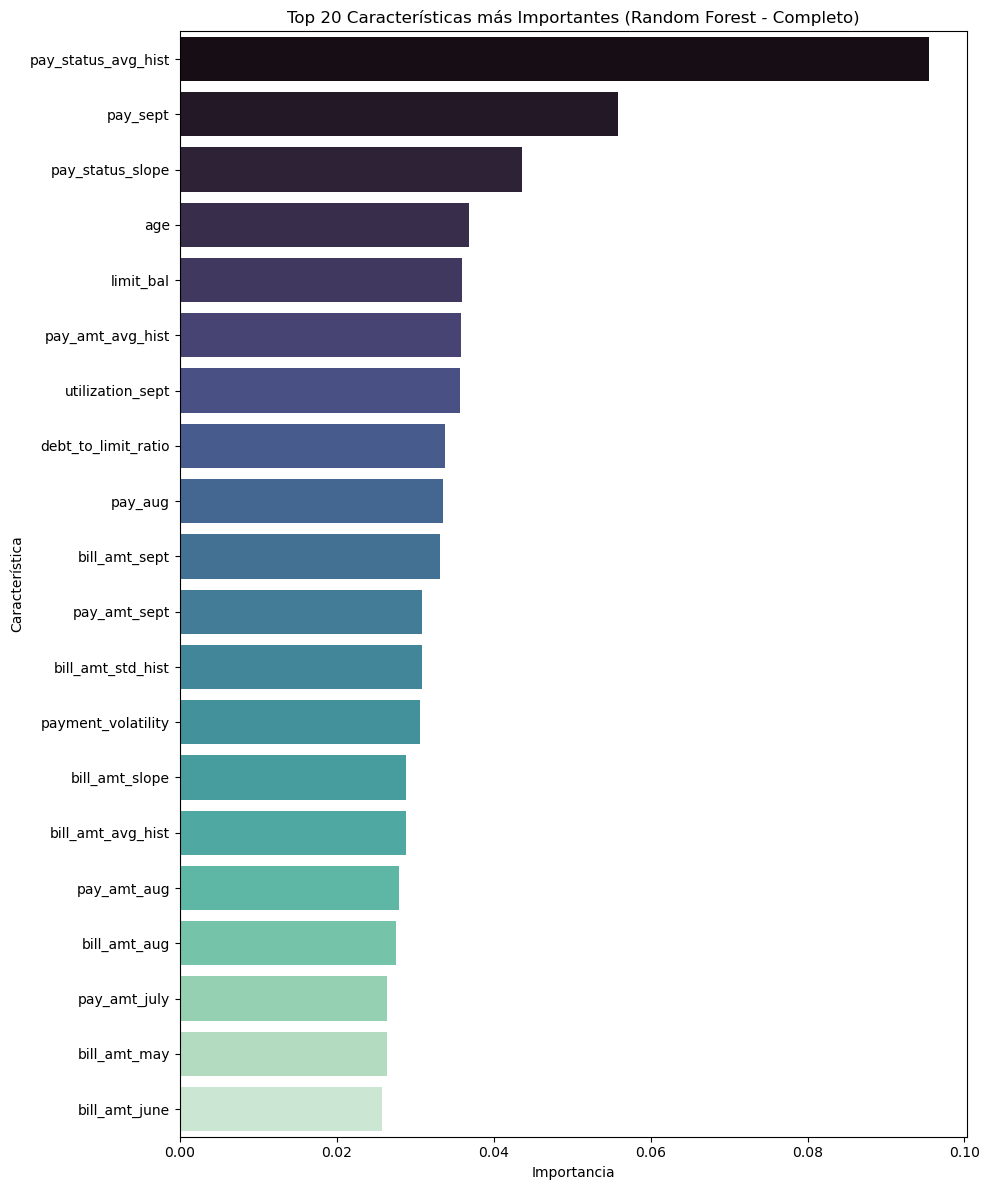

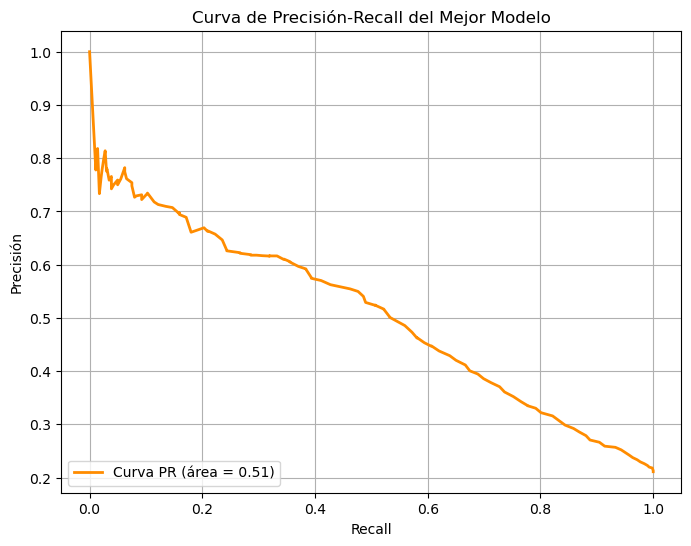

In [29]:
if 'results_df' in locals() and not results_df.empty:
    best_result = results_df.loc[results_df['F1-Score (Default)'].idxmax()]
    best_model_name = best_result['Model']
    best_dataset_name = best_result['Dataset']
    
    print(f"\n--- Análisis Profundo del Mejor Modelo: {best_model_name} en Dataset {best_dataset_name} ---")
    
    artifacts = best_result['artifacts']
    model_best = artifacts['model']
    feature_names = artifacts['feature_names']
    y_test_best = artifacts['y_test']
    y_pred_proba_best = artifacts['y_pred_proba']

    if hasattr(model_best, 'feature_importances_'):
        importances = model_best.feature_importances_
        
        # Ahora las longitudes coincidirán perfectamente
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 12))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='mako')
        plt.title(f'Top 20 Características más Importantes ({best_model_name} - {best_dataset_name})')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.tight_layout()
        plt.show()
        
    precision, recall, _ = precision_recall_curve(y_test_best, y_pred_proba_best)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Curva PR (área = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curva de Precisión-Recall del Mejor Modelo')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

In [30]:
if 'results_df' in locals() and not results_df.empty:
    print("\n--- Iniciando Optimización de Hiperparámetros para Random Forest ---")
    
    # Usar los artefactos del mejor modelo identificado
    artifacts_best = results_df.loc[results_df['F1-Score (Default)'].idxmax()]['artifacts']
    X_train_scaled_best = artifacts_best['X_train_scaled']
    y_train_res_best = artifacts_best['y_train_res']
    X_test_scaled_best = artifacts_best['X_test_scaled']
    y_test_best = artifacts_best['y_test']
    
    param_distributions = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits=3)
    
    random_search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_distributions,
        n_iter=50,
        cv=tscv,
        scoring='f1',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train_scaled_best, y_train_res_best)
    
    print("\n--- Mejores Hiperparámetros Encontrados ---")
    print(random_search.best_params_)
    
    best_rf_clf = random_search.best_estimator_
    y_pred_best_rf = best_rf_clf.predict(X_test_scaled_best)
    y_pred_proba_best_rf = best_rf_clf.predict_proba(X_test_scaled_best)[:, 1]
    
    print("\n--- Métricas de Evaluación del Modelo Random Forest OPTIMIZADO ---")
    print(f"Accuracy: {accuracy_score(y_test_best, y_pred_best_rf):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test_best, y_pred_proba_best_rf):.4f}")
    print("\nReporte de Clasificación (Optimizado):")
    print(classification_report(y_test_best, y_pred_best_rf, target_names=['No Incumplimiento', 'Incumplimiento']))


--- Iniciando Optimización de Hiperparámetros para Random Forest ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   6.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  10.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  12.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  13.8s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.9s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  17.8s
[CV] END max_depth=10, max_featu